# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [2]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('/home/vorstrel/study/data/dogs_vs_cats/train/*.jpg')
test_files = glob('/home/vorstrel/study/data/dogs_vs_cats/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    # загрузка и масштабирование изображения
    array = preprocess_input(img_to_array(load_img(path, target_size=target_size)))
    return array  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if path.split('/')[-1][0:3] == 'dog' else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

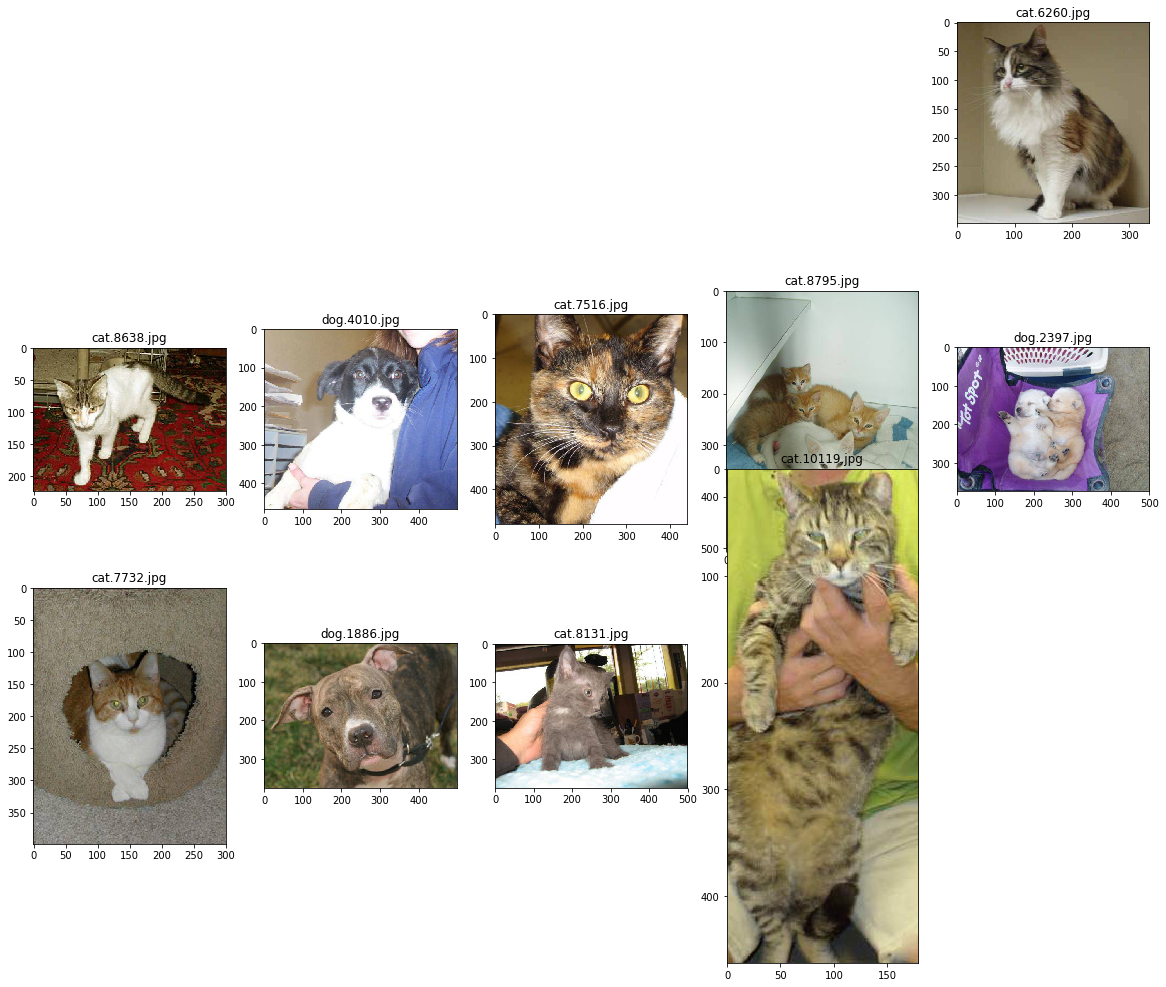

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [25]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [26]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

## Добавляем полносвязный слой

In [27]:
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                       activation='sigmoid',  # функция активации  
#                        kernel_regularizer=keras.regularizers.l1(1e-4)
                      )(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [29]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [33]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

# validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files),  # данные читаем функцией-генератором
                    steps_per_epoch=800,  # число вызовов генератора за эпоху
                    epochs=5,  # число эпох обучения
#                     validation_data=validation_data
                    callbacks=[keras.callbacks.ModelCheckpoint(
                        'subtask3_model_callback.h5', monitor='loss', save_best_only=True
                    )]
                   )

Epoch 1/5
800/800 [==============================] - 199s - loss: 0.2073 - acc: 0.9867   
Epoch 2/5
800/800 [==============================] - 198s - loss: 0.1654 - acc: 0.9895   
Epoch 3/5
800/800 [==============================] - 199s - loss: 0.1733 - acc: 0.9889   
Epoch 4/5
800/800 [==============================] - 199s - loss: 0.1571 - acc: 0.9900   
Epoch 5/5
800/800 [==============================] - 199s - loss: 0.1629 - acc: 0.9896   


In [34]:
model.save('subtask3_model.h5')

## Предсказания на проверочной выборке

In [35]:
pred = np.clip(
    model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500),
    0.0125, 0.9875
)

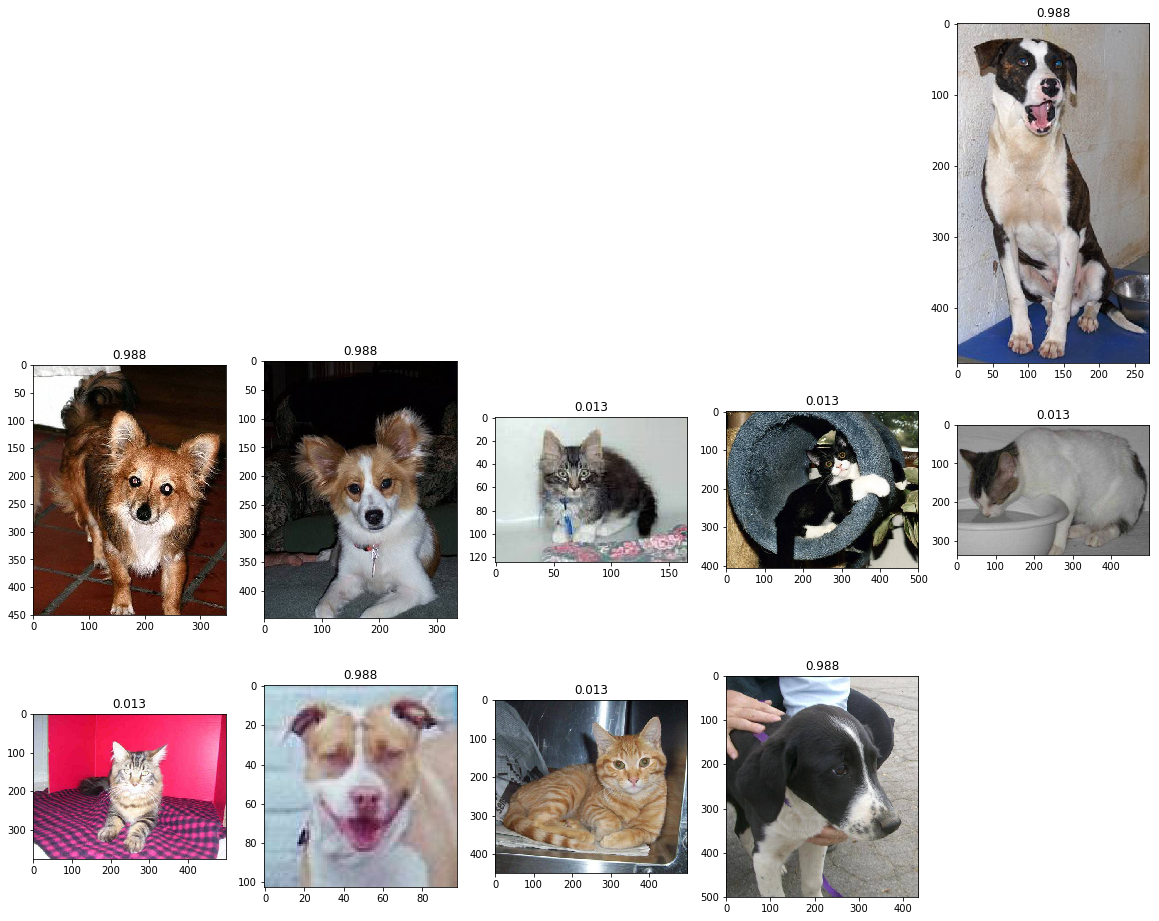

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[70:][:10], pred[70:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [39]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    names = list(int(i.split('/')[-1][:-4]) for i in test_files)
    scores = list(str(round(float(i[0]), 4)) for i in pred)
    id_score = sorted(zip(names, scores))
    for path, score in id_score:
        dst.write('{},{}\n'.format(path, score))

In [ ]:
# LogLoss = 0.11586